In [1]:
import torch
print(torch.version.cuda)


if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
print(f"Using device: {mps_device}")

None
Using device: mps


       Label                                               News
49720      0  Pakistani clerics declare transgender marriage...
49721      1  Mexico's security forces routinely use 'sexual...
49722      1  Tiny New Zealand town with 'too many jobs' lau...
49723      1  Law Enforcement Sources: Gun Used in Paris Ter...
49724      1  Ozone layer hole seems to be healing - US &amp...


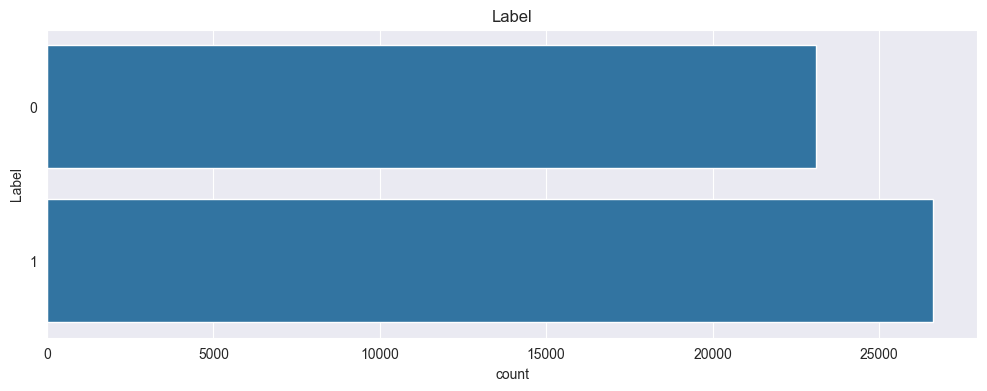

In [2]:
import pandas as pd
news_data = pd.read_csv("news.csv")
# Melt the Top1 to Top25 columns into a single column
melted_df = news_data.melt(
    id_vars=["Label"],  # Keep "Label" column as it is
    value_vars=[f"Top{i}" for i in range(1, 26)],  # Columns to unpivot
    var_name="Rank",  # Optional: name for the melted variable column
    value_name="News"  # Name for the melted value column
)

# Drop the "Rank" column as it is no longer needed
melted_df = melted_df.drop(columns=["Rank"])

# Drop rows where "News" is NaN or empty (optional)
melted_df = melted_df.dropna(subset=["News"])

news_data = melted_df

# news_data = news_data.drop(['Date'], axis=1)
# # Combine Top1-Top25 into a single string
# news_data['combined_text'] = news_data.iloc[:, 1:].apply(lambda x: " ".join(x.dropna()), axis=1)
# columns_2 = ['Top1','Top2','Top3', 'Top4', 'Top5','Top6', 'Top7', 'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23','Top24', 'Top25']
# news_data = news_data.drop(columns_2, axis=1)
news_data = news_data.replace('b\"|b\'|\\\\|\\\"', '', regex=True)
print(news_data.tail())
# news_data['combined_text'] = news_data['combined_text'].apply(lambda x:x.lower())
# news_data.tail()
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
sns.countplot(y=news_data['Label'])
plt.title('Label')
plt.show();

<Figure size 1000x1000 with 0 Axes>

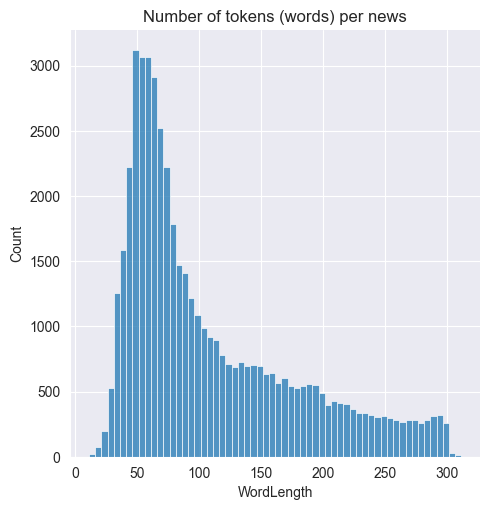

In [3]:
news_data['WordLength'] = news_data['News'].str.len()
fig = plt.figure(figsize=(10,10))
sns.displot(news_data['WordLength'])
plt.title('Number of tokens (words) per news')
plt.show();

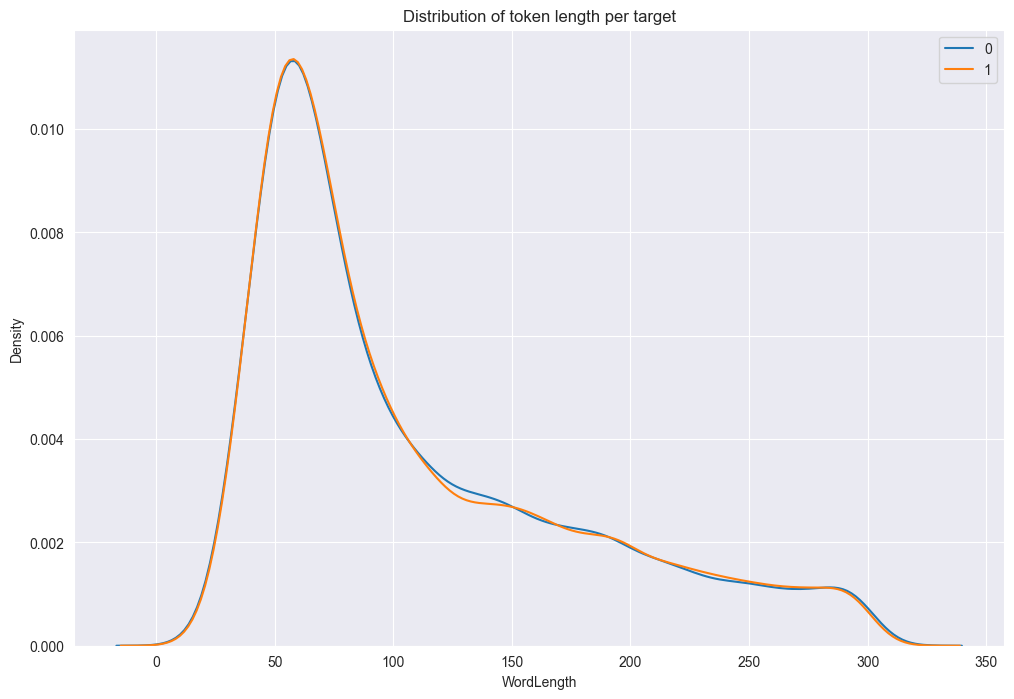

In [4]:
fig, ax = plt.subplots(figsize=(12,8))
for sentiment in [0, 1]:
    sns.kdeplot(news_data[news_data['Label']==sentiment]['WordLength'],ax=ax, label=sentiment)
ax.legend()
ax.set_title('Distribution of token length per target')
plt.show();

In [5]:
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, AutoTokenizer


class TextDataset(Dataset):
    def __init__(self, dataframe, max_length=512, tokenizer_name='bert-base-uncased'):
        self.texts = dataframe['News'].values
        self.targets = dataframe['Label'].values
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()
        
        return {
            'input_ids': torch.as_tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.as_tensor(attention_mask, dtype=torch.long),
            'targets': torch.as_tensor(target, dtype=torch.long),
            'text': text
        }

In [6]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(news_data, train_size=0.9, shuffle=True)
print('{:>5,} Training samples'.format(len(train_data)))
print('{:>5,} Test samples'.format(len(test_data)))
# Create custom Datasets
train_dataset = TextDataset(train_data)
test_dataset = TextDataset(test_data)

from torch.utils.data import DataLoader
BATCH_SIZE = 16

torch.manual_seed(42)
train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader = DataLoader(test_dataset,
                         batch_size=len(test_dataset))
next(iter(train_loader))

44,746 Training samples
4,972 Test samples


{'input_ids': tensor([[  101,  2329,  2231,  ...,     0,     0,     0],
         [  101,  3956, 14308,  ...,     0,     0,     0],
         [  101,  2900,  2000,  ...,     0,     0,     0],
         ...,
         [  101,  1999,  1996,  ...,     0,     0,     0],
         [  101,  8174,  9264,  ...,     0,     0,     0],
         [  101,  3082,  3554,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'targets': tensor([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]),
 'text': ['British government finally apologises for a soldier who shot a 12-year-old girl in the back as she walked to church. Soldier not jailed.',
  "Israel slaps wrists of officers in charge of white phosphorous shelling of a Gaza UN compound, claims: The most important thing that... we have absolu

In [7]:
#from torch import cuda
#torch.cuda.empty_cache()
device = 'mps'

from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
EPOCHS = 3

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8)
import time
import datetime
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

torch.autograd.set_detect_anomaly(True) 

training_stats = []
epoch_loss_train = []
total_t0 = time.time()

# TRAINING
for epoch in range(1, EPOCHS + 1):
    model.train()
    t0 = time.time()
    print("")
    print("================ Epoch {:} / {:} ================".format(epoch, EPOCHS))
    train_all_predictions = []
    train_all_true_labels = []
    for step, data in enumerate(train_loader):
        if step % 2 == 0 and not step == 0:
            elapsed = int(round(time.time() - t0))
            elapsed = str(datetime.timedelta(seconds=elapsed))
            print(
                "  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.".format(
                    step, len(train_loader), elapsed
                )
            )
            print(epoch_loss_train)

        targets = data["targets"].to(device)
        mask = data["attention_mask"].to(device)
        ids = data["input_ids"].to(device)

        model.zero_grad()

        loss, logits = model(
            ids, token_type_ids=None, attention_mask=mask, labels=targets
        ).to_tuple()
        epoch_loss_train.append(loss.item())

        cpu_logits = logits.cpu().detach().numpy()
        train_all_predictions.extend(np.argmax(cpu_logits, axis=1).flatten())
        train_all_true_labels.extend(targets.cpu().numpy())

        loss.backward()
        optimizer.step()
    train_accuracy = accuracy_score(train_all_true_labels, train_all_predictions)
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
        train_all_true_labels, train_all_predictions, average="binary"
    )
    print("")
    print('---TRAIN METRICS---')
    print(f"Loss: {np.mean(epoch_loss_train):.4f}")
    print(f"Accuracy: {train_accuracy:.4f}")
    print(f"Precision: {train_precision:.4f}")
    print(f"Recall: {train_recall:.4f}")
    print(f"F1-Score: {train_f1:.4f}")
    print("")
    
    # VALIDATION
    # print("Running validation ...")
    # print("")
    # model.eval()
    # epoch_loss_test = []
    # test_all_predictions = []
    # test_all_true_labels = []
    # for data in test_loader:
    #     targets = data["targets"].to(device)
    #     mask = data["attention_mask"].to(device)
    #     ids = data["input_ids"].to(device)
    #     
    #     with torch.no_grad():
    #         loss, logits = model(ids, token_type_ids=None, attention_mask=mask, labels=targets).to_tuple()
    #         
    #     epoch_loss_test.append(loss.item())
    #     cpu_logits = logits.cpu().detach().numpy()
    #     test_all_predictions.extend(np.argmax(cpu_logits, axis=1).flatten())
    #     test_all_true_labels.extend(targets.cpu().numpy())
    # test_accuracy = accuracy_score(test_all_true_labels, test_all_predictions)
    # test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    #     test_all_true_labels, test_all_predictions, average="binary"
    # )
    # print("")
    # print('---TEST METRICS---')
    # print(f"Loss: {np.mean(epoch_loss_test):.4f}")
    # print(f"Accuracy: {test_accuracy:.4f}")
    # print(f"Precision: {test_precision:.4f}")
    # print(f"Recall: {test_recall:.4f}")
    # print(f"F1-Score: {test_f1:.4f}")
    # 
    # training_stats.append(
    #         {
    #         'epoch': epoch,
    #         'Training Loss': np.mean(epoch_loss_train),
    #         'Training Accuracy': train_accuracy,
    #         'Training Precision': train_precision,
    #         'Training Recall': train_recall,
    #         'Training F1': train_f1,
    #         'Validation Loss': np.mean(epoch_loss_test),
    #         'Validation Accuracy': test_accuracy,
    #         'Validation Precision': test_precision,
    #         'Validation Recall': test_recall,
    #         'Validation F1': test_f1
    #     }
    # )


================ Epoch 1 / 3 ================


RuntimeError: MPS backend out of memory (MPS allocated: 17.76 GB, other allocations: 309.75 MB, max allowed: 18.13 GB). Tried to allocate 96.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).